#### Environment Set-Up

In [35]:
# Set the number of threads
import os

os.environ["OMP_NUM_THREADS"] = str(os.cpu_count())

In [36]:
# Reload function after adjustment
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Import Necessary Packages and Modules 

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.metrics import silhouette_score
import scipy.stats as stats
import datetime as dt
import pickle
from functools import reduce
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from mpl_toolkits.mplot3d import Axes3D

# Custom package
from utility.utility_functions import load_data,combine_data_from_file,perform_eda,drop_duplicate,dist_plot,cormat

In [38]:
# Set Chart fontsize, number of columns for pd.DataFrame
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 4000)
plt.style.use('ggplot')
mpl.rcParams['font.size'] = 10

## Loading the Dataset

The dataset [rovided by the ecommerce company is in 2 different sheets, so we need to first combine the data from the sheets.

In [39]:
# Combine the datasets
file_path = "./raw/online_retail_Data.xlsb"
sheet_name = ['Year 2009-2010','Year 2010-2011']


# Combine the data - Self defined functions in the utility module
combine_data_from_file(file_path ,sheet_name)

Data combined and saved successfully to processed_data\combined_data.csv


Next, we will load the combined data into a pandas DataFrame, using a self defined function `load_data`

In [40]:
# Path to the combined dataset
data_path="./processed_data/combined_data.csv"

# Load into a dataframe
data_df = load_data(data_path)

## Data Cleaning & Exploratory Data Analysis (EDA)

Before jumping into the tasks, let's try to get some information about the dataset

In [41]:
# Perform a general overview of the dataset

perform_eda(data_df)  # Custom function for general information

The First 5 Rows of the Dataset
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS      12.0   
1  489434    79323P                   PINK CHERRY LIGHTS      12.0   
2  489434    79323W                  WHITE CHERRY LIGHTS      12.0   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE       48.0   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX      24.0   

    InvoiceDate  Price  Customer ID         Country  
0  40148.322917   6.95      13085.0  United Kingdom  
1  40148.322917   6.75      13085.0  United Kingdom  
2  40148.322917   6.75      13085.0  United Kingdom  
3  40148.322917   2.10      13085.0  United Kingdom  
4  40148.322917   1.25      13085.0  United Kingdom  
The Last 5 Rows of the Dataset
       Invoice StockCode                      Description  Quantity  \
159119  540026     22697  GREEN REGENCY TEACUP AND SAUCER       1.0   
159120  540026     22713              CARD I LOVE 

From the above, some issues were identified

* From `Missing Data by Column`, it is evident that the combined dataset has empty/blank rows.
* The dataset contains duplicates
* Incorrect datatype for `Customer ID` and `InvoiceDate`
* `Quantity` and `Price` have negative values
* Using the Unique values Count,  `StockCode` and `Description` are inconsistent
* `Customer ID` contains `NaN` values

To ensure all issues are identified, let's first remove the empty rows, remove duplicates and correct datatype for InvoiceDate

In [42]:
# Remove empty rows
data_df1 = data_df[~data_df.isnull().all(axis=1)]

# Remove duplicates
data_df1 = drop_duplicate(data_df1)

# Correct Inconsistent datatypes for Invoice date
data_df1['InvoiceDate'] = pd.to_datetime(data_df1['InvoiceDate'],origin='1899-12-30', unit='D')

**To be able to identify all the possible issues, I will examine the columns in the dataset one by one** 

##### Invoice

In [43]:
# Checking number of unique Invoices

len(data_df1['Invoice'].unique())

1983

In [44]:
# Checking 10 rows of Invoice at random
data_df1['Invoice'].sample(10)

143989    507292
146998    507604
143883    507290
151340    508175
151033    508097
143781    507289
137046    506680
134585    506394
157276    508854
139272    506876
Name: Invoice, dtype: object

**The above shows that some of the Invoices start with alphabets. They most probably represent cancelled/abandon orders**

In [45]:
# Checking the number of rows with such occurences

print(data_df1['Invoice'].str[0].str.isalpha().sum())

872


There are 872 Invoices (non unique) that starts with letters 

In [46]:
# Let's confirm this

data_df1[data_df1['Invoice'].str[0].str.isalpha()]['Invoice'].value_counts()

Invoice
C508384    28
C508499    20
C508186    15
C506979    15
C507118    15
           ..
C508698     1
C508726     1
C506485     1
C506488     1
C506489     1
Name: count, Length: 362, dtype: int64

#### Description

In [47]:
# Checking for top 5 rows of the description column
data_df1['Description'].head()

0    15CM CHRISTMAS GLASS BALL 20 LIGHTS
1                     PINK CHERRY LIGHTS
2                    WHITE CHERRY LIGHTS
3           RECORD FRAME 7" SINGLE SIZE 
4         STRAWBERRY CERAMIC TRINKET BOX
Name: Description, dtype: object

In [48]:
# Checking at random top 10 of the description column
data_df1['Description'].sample(10)

138767       SET OF 36 PAISLEY FLOWER DOILIES
154244        PACK 4 FLOWER/BUTTERFLY PATCHES
144867            MOUSE TOY WITH PINK T-SHIRT
149193    GARDENIA 3 WICK MORRIS BOXED CANDLE
150347       CAKE STAND LOVEBIRD 2 TIER WHITE
154259      CERAMIC CAKE DESIGN SPOTTED PLATE
134459              ROSE DU SUD CUSHION COVER
141364                 SEASIDE STRIPE HAMMOCK
150413                 WHITE LOVEBIRD LANTERN
146202      S/6 WOODEN SKITTLES IN COTTON BAG
Name: Description, dtype: object

The above shows that there are missing description in  the dataset.
Let's take a closer look at the `StockCode` and `Description`

In [49]:
# Checking for missing values for both columns
data_df1[['StockCode', 'Description']].isnull().sum()

StockCode        0
Description    350
dtype: int64

There are 350 missing data for the `Description` column

In [50]:
# let's check for the rows that correspond to these
data_df1[(data_df1['StockCode'].notnull()) & (data_df1['Description'].isnull())]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
470,489521,21646,NaN,-50.0,2009-12-01 11:44:00.000000018,0.0,NaN,United Kingdom
986,493494,21231,NaN,-84.0,2010-01-04 14:55:59.999999842,0.0,NaN,United Kingdom
987,493508,20887,NaN,9.0,2010-01-04 15:08:00.000000306,0.0,NaN,United Kingdom
988,493510,40046C,NaN,7.0,2010-01-04 15:08:00.000000306,0.0,NaN,United Kingdom
989,493509,21558,NaN,7.0,2010-01-04 15:08:00.000000306,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
158647,540000,84499,NaN,-9.0,2011-01-04 10:16:59.999999972,0.0,NaN,United Kingdom
158705,540008,85230F,NaN,-48.0,2011-01-04 11:10:00.000000278,0.0,NaN,United Kingdom
158706,540009,22158,NaN,-120.0,2011-01-04 11:10:00.000000278,0.0,NaN,United Kingdom
158708,540011,22501,NaN,30.0,2011-01-04 11:13:00.000000863,0.0,NaN,United Kingdom


For the above cases, the `Price` is 0 when there is no customer ID attached to these transactions

In [51]:
# Group by StockCode and count unique descriptions
description_counts = data_df1.groupby('StockCode')['Description'].nunique()

# Find stock codes with more than one unique description
inconsistent_stock_codes = description_counts[description_counts > 1].index

# Filter the original dataset for rows with these inconsistent stock codes
inconsistent_descriptions = data_df1[data_df1['StockCode'].isin(inconsistent_stock_codes)].sort_values(by='StockCode', ascending=True)

# Display the result
print(inconsistent_descriptions)


       Invoice StockCode                         Description  Quantity  \
149645  507913     10120                 Zebra invcing error   -9000.0   
658     493435     10120                        DOGGY RUBBER      30.0   
133614  506285     10120                        DOGGY RUBBER      30.0   
145482  507401     17033     BROCADE PURSE,SMALL ARCH BUTTON      36.0   
148347  507707     17033     BROCADE PURSE,SMALL ARCH BUTTON     322.0   
...        ...       ...                                 ...       ...   
154101  508486    85123A  WHITE HANGING HEART T-LIGHT HOLDER      10.0   
139954  506965    85123A  WHITE HANGING HEART T-LIGHT HOLDER       6.0   
158124  536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER       6.0   
146284  507446    85123A  WHITE HANGING HEART T-LIGHT HOLDER       6.0   
156560  508745    85123A  WHITE HANGING HEART T-LIGHT HOLDER      10.0   

                         InvoiceDate  Price  Customer ID          Country  
149645 2010-05-11 17:16:00.00000019

The above shows that `Description` for the same StockCode is not consistent, as a stockcode can have multiple description.

#### Quantity

In [52]:
# Check for missing data

print(data_df1['Quantity'].isnull().sum())

0


No missing values. However, we identified earlier that `Quantity` have negative values. Let's explore this

In [53]:
# Check the Number of Observations in the 'Quantity' Column Which are Below 0
(data_df1['Quantity']<0).value_counts()

Quantity
False    27418
True      1149
Name: count, dtype: int64

In [54]:
# The Number of Observations in the 'Quantity' Column Which are 0
(data_df1['Quantity']==0).value_counts()

Quantity
False    28567
Name: count, dtype: int64

Good, we do not have cases where Quantity is 0. So we continue to investigate where Quantity <0

In [55]:
# Checking the rows that have negative quantity
data_df1[data_df1['Quantity']<0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12.0,2009-12-01 10:32:59.999999953,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6.0,2009-12-01 10:32:59.999999953,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4.0,2009-12-01 10:32:59.999999953,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6.0,2009-12-01 10:32:59.999999953,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12.0,2009-12-01 10:32:59.999999953,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
158704,C540007,22274,FELTCRAFT DOLL EMILY,-6.0,2011-01-04 11:07:59.999999888,2.95,15379.0,United Kingdom
158705,540008,85230F,NaN,-48.0,2011-01-04 11:10:00.000000278,0.00,NaN,United Kingdom
158706,540009,22158,NaN,-120.0,2011-01-04 11:10:00.000000278,0.00,NaN,United Kingdom
158707,540010,22501,reverse 21/5/10 adjustment,-100.0,2011-01-04 11:13:00.000000863,0.00,NaN,United Kingdom


In [56]:
# Checking the rows that have positive quantity
data_df1[data_df1['Quantity']>0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01 07:44:59.999999164,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009-12-01 07:44:59.999999164,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009-12-01 07:44:59.999999164,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2009-12-01 07:44:59.999999164,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01 07:44:59.999999164,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
159119,540026,22697,GREEN REGENCY TEACUP AND SAUCER,1.0,2011-01-04 13:25:00.000000278,5.91,NaN,United Kingdom
159120,540026,22713,CARD I LOVE LONDON,2.0,2011-01-04 13:25:00.000000278,0.85,NaN,United Kingdom
159121,540026,85087,CANDY SPOT CUSHION COVER,2.0,2011-01-04 13:25:00.000000278,3.36,NaN,United Kingdom
159122,540026,DOT,DOTCOM POSTAGE,1.0,2011-01-04 13:25:00.000000278,469.70,NaN,United Kingdom


When we filter out negative Quantity, the `Price` is positive. It is evident that negative `Quantity` means that the order was returned

#### Price

In [57]:
# Check for missing data

print(data_df1['Price'].isnull().sum())

0


There are no missing values for `Price`

In [58]:
# Check the Number of Observations in the 'Price' Column <=0
(data_df1['Price']<=0).value_counts()

Price
False    28116
True       451
Name: count, dtype: int64

451 of the prices in the dataset are either negative or 0

In [59]:
# Checking the rows that have negative quantity
data_df1[data_df1['Price']<=0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96.0,2009-12-01 10:51:59.999999898,0.0,NaN,United Kingdom
283,489463,71477,short,-240.0,2009-12-01 10:51:59.999999898,0.0,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192.0,2009-12-01 10:53:00.000000101,0.0,NaN,United Kingdom
470,489521,21646,NaN,-50.0,2009-12-01 11:44:00.000000018,0.0,NaN,United Kingdom
986,493494,21231,NaN,-84.0,2010-01-04 14:55:59.999999842,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
158706,540009,22158,NaN,-120.0,2011-01-04 11:10:00.000000278,0.0,NaN,United Kingdom
158707,540010,22501,reverse 21/5/10 adjustment,-100.0,2011-01-04 11:13:00.000000863,0.0,NaN,United Kingdom
158708,540011,22501,NaN,30.0,2011-01-04 11:13:00.000000863,0.0,NaN,United Kingdom
158709,540012,22502,reverse 21/5/10 adjustment,-100.0,2011-01-04 11:13:59.999999805,0.0,NaN,United Kingdom


The above shows that there are no customer ID where the price is less than or equal to 0, and in fact most of these have negative `Quantity`. Now, Let's study the `Customer ID`

#### Customer ID

In [60]:
data_df1['Customer ID'].value_counts()

Customer ID
14911.0    464
17841.0    369
14156.0    277
14298.0    274
14606.0    211
          ... 
15586.0      1
15100.0      1
17809.0      1
12362.0      1
12636.0      1
Name: count, Length: 921, dtype: int64

4697 rows do not have customer ID

In [61]:
# Let's check these cases
data_df1[data_df1['Customer ID'].isnull()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96.0,2009-12-01 10:51:59.999999898,0.00,NaN,United Kingdom
283,489463,71477,short,-240.0,2009-12-01 10:51:59.999999898,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192.0,2009-12-01 10:53:00.000000101,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50.0,2009-12-01 11:44:00.000000018,0.00,NaN,United Kingdom
503,493413,21724,PANDA AND BUNNIES STICKER SHEET,1.0,2010-01-04 09:53:59.999999870,0.85,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
159119,540026,22697,GREEN REGENCY TEACUP AND SAUCER,1.0,2011-01-04 13:25:00.000000278,5.91,NaN,United Kingdom
159120,540026,22713,CARD I LOVE LONDON,2.0,2011-01-04 13:25:00.000000278,0.85,NaN,United Kingdom
159121,540026,85087,CANDY SPOT CUSHION COVER,2.0,2011-01-04 13:25:00.000000278,3.36,NaN,United Kingdom
159122,540026,DOT,DOTCOM POSTAGE,1.0,2011-01-04 13:25:00.000000278,469.70,NaN,United Kingdom


In [62]:
data_df1[data_df1['Customer ID'].isnull()]['StockCode'].value_counts()

StockCode
DOT       38
47566     27
22423     21
22090     19
21232     18
          ..
22453      1
22457      1
90200A     1
90200D     1
90202C     1
Name: count, Length: 1752, dtype: int64

The above shows that most of the rows where the customer IDs are missing are `DOTCOM POSTAGE` or cases where `Quantity`<0

**Let's remove orders which do NOT have customer ID's, as these do not correspond to actual sales** 

In [63]:
data_df2 = data_df1.dropna(subset=["Customer ID"])

**Now let's handle cancellations and negative `Quantity` in the given dataset.**

In [64]:
data_df3 = data_df2[(data_df2['Price'] > 0) & (data_df2['Quantity'] > 0)]

In [65]:
# Change the customer id datatype to int
data_df3.loc[:,'Customer ID'] = data_df3['Customer ID'].apply(lambda x: int(x))

# Now, let's check the dataset again
perform_eda(data_df3)

The First 5 Rows of the Dataset
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS      12.0   
1  489434    79323P                   PINK CHERRY LIGHTS      12.0   
2  489434    79323W                  WHITE CHERRY LIGHTS      12.0   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE       48.0   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX      24.0   

                    InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:44:59.999999164   6.95      13085.0  United Kingdom  
1 2009-12-01 07:44:59.999999164   6.75      13085.0  United Kingdom  
2 2009-12-01 07:44:59.999999164   6.75      13085.0  United Kingdom  
3 2009-12-01 07:44:59.999999164   2.10      13085.0  United Kingdom  
4 2009-12-01 07:44:59.999999164   1.25      13085.0  United Kingdom  
The Last 5 Rows of the Dataset
       Invoice StockCode                         Description  Quantity  \
159023  540025     228

In [66]:
data_df3.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01 07:44:59.999999164,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009-12-01 07:44:59.999999164,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009-12-01 07:44:59.999999164,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2009-12-01 07:44:59.999999164,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01 07:44:59.999999164,1.25,13085.0,United Kingdom


In [68]:
# Now, let's obtain Revenue

data_df3.loc[:,'Revenue'] = data_df3['Quantity']*data_df3['Price']


## Exploratory Data Analysis (EDA)

**In this section, we will look at**
* Top 10 Country by Total Sales
* Top Products by Sales Volume
* The most popular product by Country
* Customer Purchase Frequency
* Average Order Quantity By Customers
* Monthly Sales Trend
* Distribution of New and Returning Customers By Month

#### Top 10 Country by Total Sales

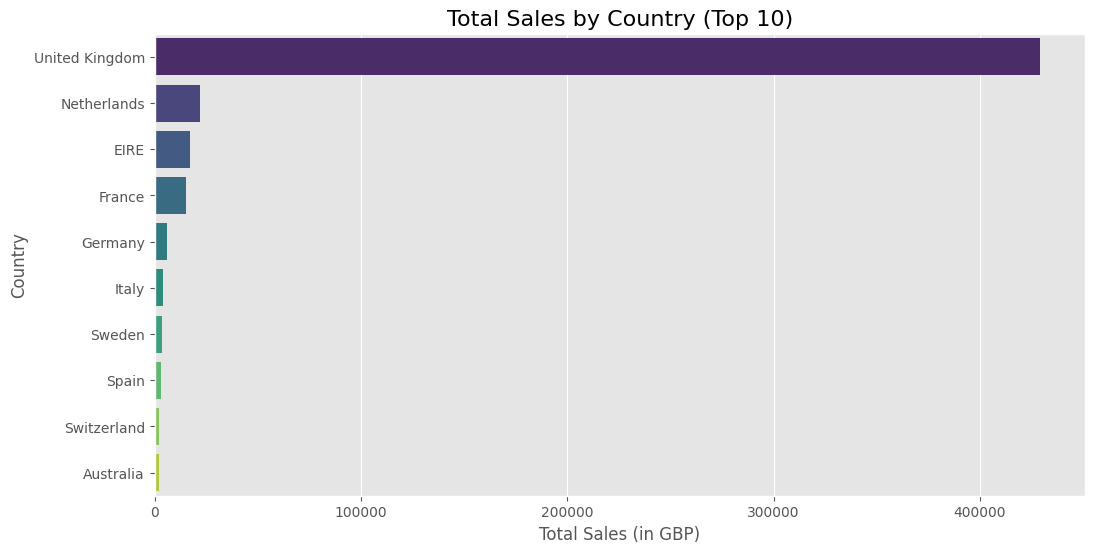

In [69]:
# Calculate total sales by country
sales_by_country = data_df3.groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=sales_by_country.values, y=sales_by_country.index,hue=sales_by_country.index,legend=False,palette='viridis')
plt.title('Total Sales by Country (Top 10)', fontsize=16)
plt.xlabel('Total Sales (in GBP)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.show()

*The above shows that the most significant Market for the Ecommerce company is `United Kingdom`*

#### Top Products by Sales Volume

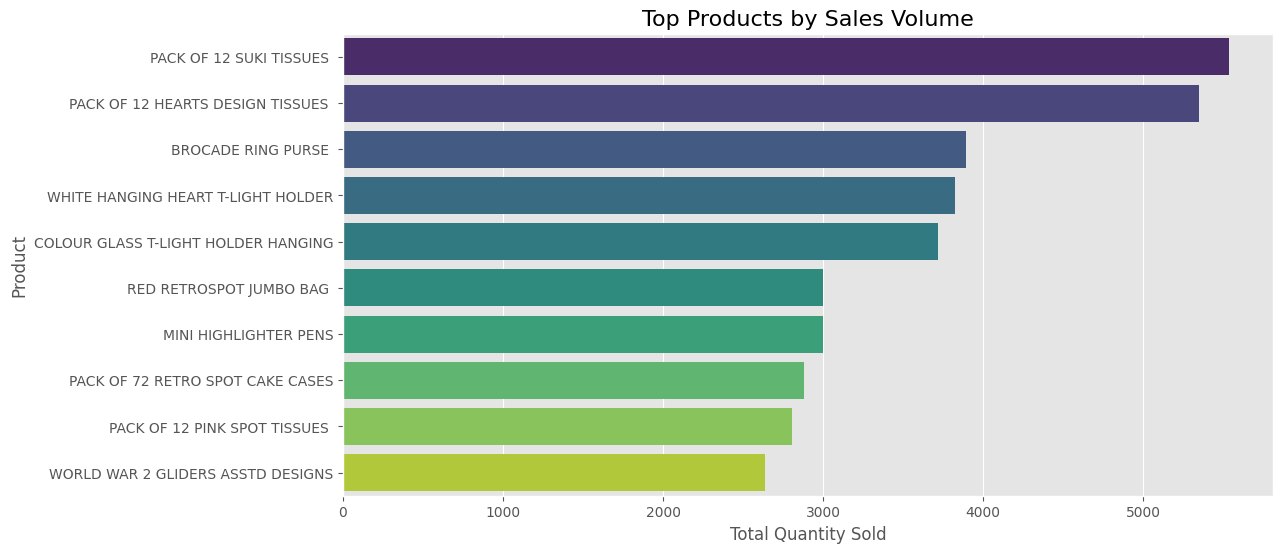

In [70]:
# Calculate total quantity sold per product
top_products = data_df3.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_products.values, y=top_products.index,
                hue=top_products.index,  # Use y variable as hue
                palette='viridis',
                legend=False  # Hide the legend
)
plt.title('Top Products by Sales Volume', fontsize=16)
plt.xlabel('Total Quantity Sold', fontsize=12)
plt.ylabel('Product', fontsize=12)
plt.show()


#### The Most Popular Product By Country

In [71]:
# Let's look at The most popular product by country
country_product_sales = data_df3.groupby(['Country','Description'])['Quantity'].sum().reset_index()
most_popular_by_country = country_product_sales.loc[country_product_sales.groupby('Country')['Quantity'].idxmax()].sort_values(by='Quantity',ascending=False)

print(most_popular_by_country)

              Country                          Description  Quantity
3240   United Kingdom             PACK OF 12 SUKI TISSUES     5414.0
1702           Sweden                MINI HIGHLIGHTER PENS    2880.0
412              EIRE       HANGING JAM JAR T-LIGHT HOLDER     696.0
1526      Netherlands    MINI PAINT SET VINTAGE  BOY+ GIRL     576.0
1657            Spain     LARGE HANGING GLASS+ZINC LANTERN     560.0
849            France                    GUMBALL COAT RACK     312.0
1061          Germany            ASSORTED COLOURS SILK FAN     240.0
1426            Italy          SET/6 RED SPOTTY PAPER CUPS     132.0
1784      Switzerland  SNOWSTORM PHOTO FRAME FRIDGE MAGNET      96.0
1602        Singapore                GRAND CHOCOLATECANDLE      72.0
101           Belgium               MINI JIGSAW DOLLY GIRL      48.0
1797              USA          60 TEATIME FAIRY CAKE CASES      48.0
152   Channel Islands       PACK OF 60 SPACEBOY CAKE CASES      48.0
1233           Greece          HAN

**The above shows the Best-Selling product for each of the Countries. `PACK OF 12 SUKI TISSUES` is the flagship product for the company and, is the most popular product in `United Kingdom`, which explains why `United Kingdom` is the Most Significant Market**

#### Customer Purchase Frequency

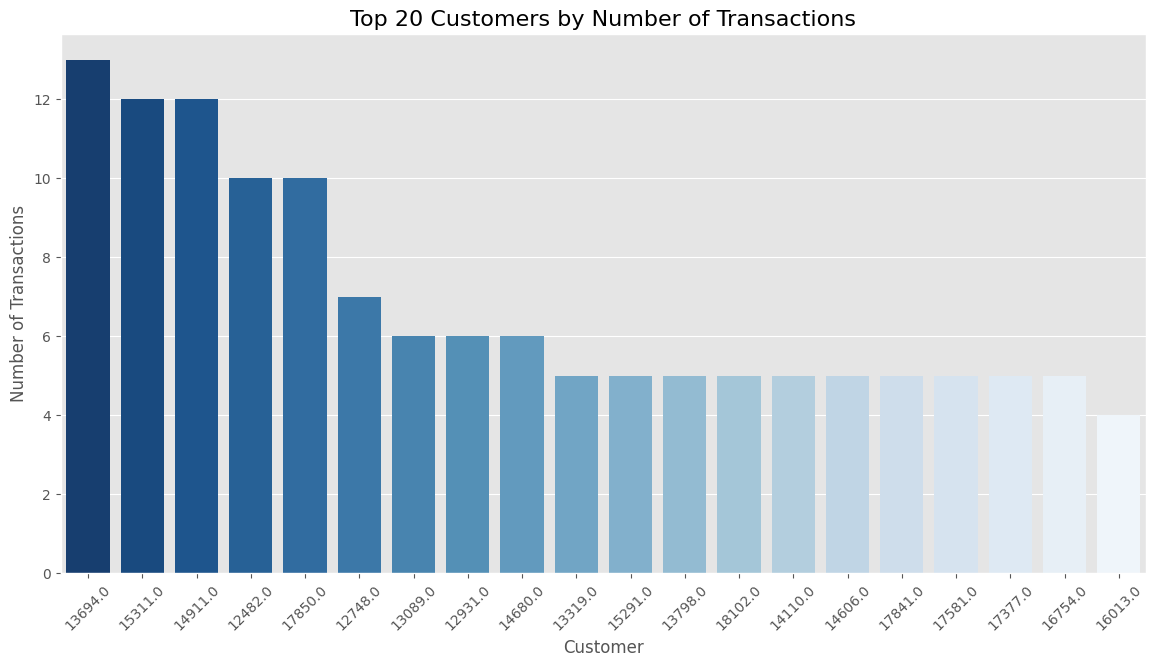

In [72]:
# Plot the number of transactions per customer
transactions_per_customer = data_df3.groupby(['Customer ID'])['Invoice'].nunique().sort_values(ascending=False).head(20)

plt.figure(figsize=(14, 7))
sns.barplot(
    x=transactions_per_customer.index.astype(str),  # Convert index to string for better display on x-axis
    y=transactions_per_customer.values,hue=transactions_per_customer.index.astype(str),
    palette='Blues_r'
)

plt.title('Top 20 Customers by Number of Transactions', fontsize=16)
plt.xlabel('Customer', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

The top customer with highest purchase frequency is `13694` followed by `15311`. Let's validate this with Average Order Quantity per transaction.

#### Top 20 Customer by Average Order Quantity

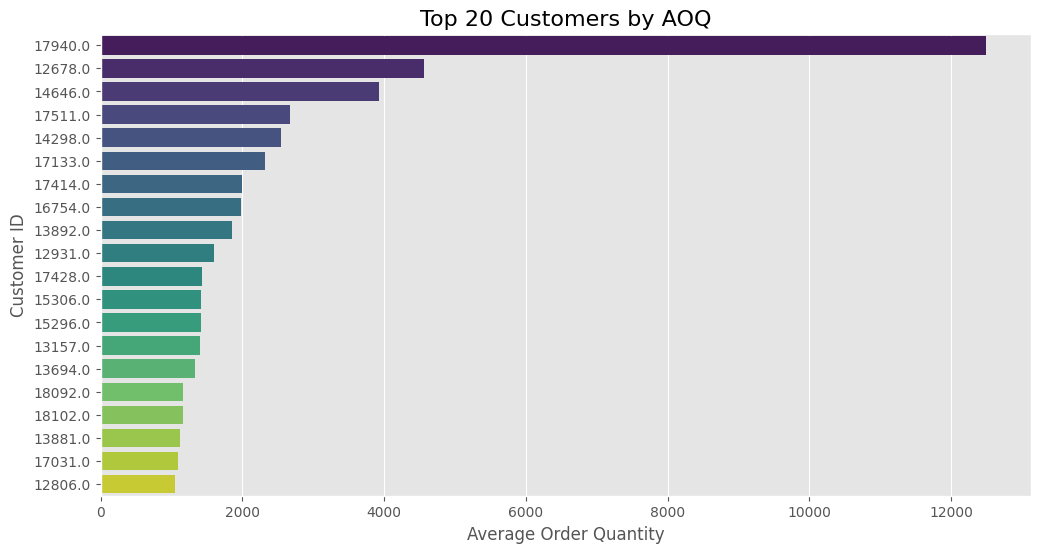

In [73]:
# Group by Customer ID abd InvoiceNo and sum up the Quantity for each order by the customer
total_qty_by_customer_invoice=data_df3.groupby(['Customer ID','Invoice'])['Quantity'].sum()

# Calculate the Average Order Quantity
aoq_by_customer=total_qty_by_customer_invoice.groupby(['Customer ID']).mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(
    y=aoq_by_customer.index.astype(str),  # Convert index to string for better display
    x=aoq_by_customer.values,
    hue=aoq_by_customer.index.astype(str),  # Use y variable as hue
    palette='viridis',
    legend=False  # Hide the legend
)

plt.title('Top 20 Customers by AOQ', fontsize=16)
plt.xlabel('Average Order Quantity', fontsize=12)
plt.ylabel('Customer ID', fontsize=12)
plt.show()

The top customer with highest AOQ is `17940` followed by `12678`, which are different from the top customers in terms of Purchase Frequency.

#### Monthly Sales Trend

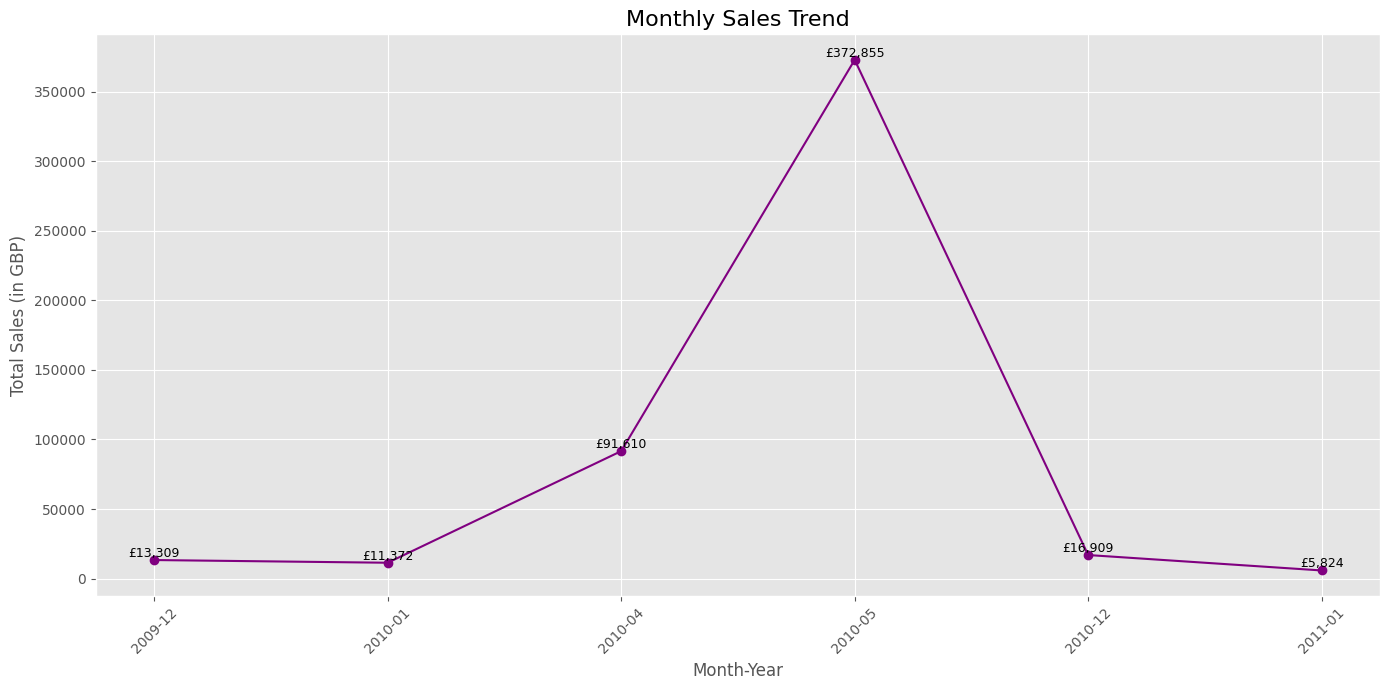

In [75]:
# Extract month and year for aggregation
data_df3.loc[:, 'MonthYear'] = data_df3['InvoiceDate'].dt.to_period('M')

# Calculate total sales per month
monthly_sales = data_df3.groupby('MonthYear')['Revenue'].sum()

# Plot
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales.index.astype(str), monthly_sales.values, color='purple', marker='o')

# Add data labels
for i, value in enumerate(monthly_sales.values):
    plt.text(i, value, f'£{value:,.0f}', ha='center', va='bottom', fontsize=9)

# Customization for full x-axis labels
plt.xticks(ticks=range(len(monthly_sales.index)), labels=monthly_sales.index.astype(str), rotation=45)

plt.title('Monthly Sales Trend', fontsize=16)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Total Sales (in GBP)', fontsize=12)
plt.grid(True)
plt.tight_layout()  # Adjust layout for better display
plt.show()

The company experienced the highest sales in the month of May, in 2010, and the lowest in January 2011

#### Distribution of New Vs Returning Customers By Month

In [76]:
# Find the first purchase date for each customer
first_purchase_date = data_df3.groupby('Customer ID')['InvoiceDate'].min().reset_index()
first_purchase_date.columns = ['Customer ID', 'FirstPurchaseDate']

# Merge this information back with the original data
data_df3 = pd.merge(data_df3, first_purchase_date, on='Customer ID', how='left')

# Create a column to label customers as 'New' or 'Returning'
data_df3['CustomerType'] = data_df3.apply(
    lambda row: 'New' if row['InvoiceDate'] == row['FirstPurchaseDate'] else 'Returning',
    axis=1
)


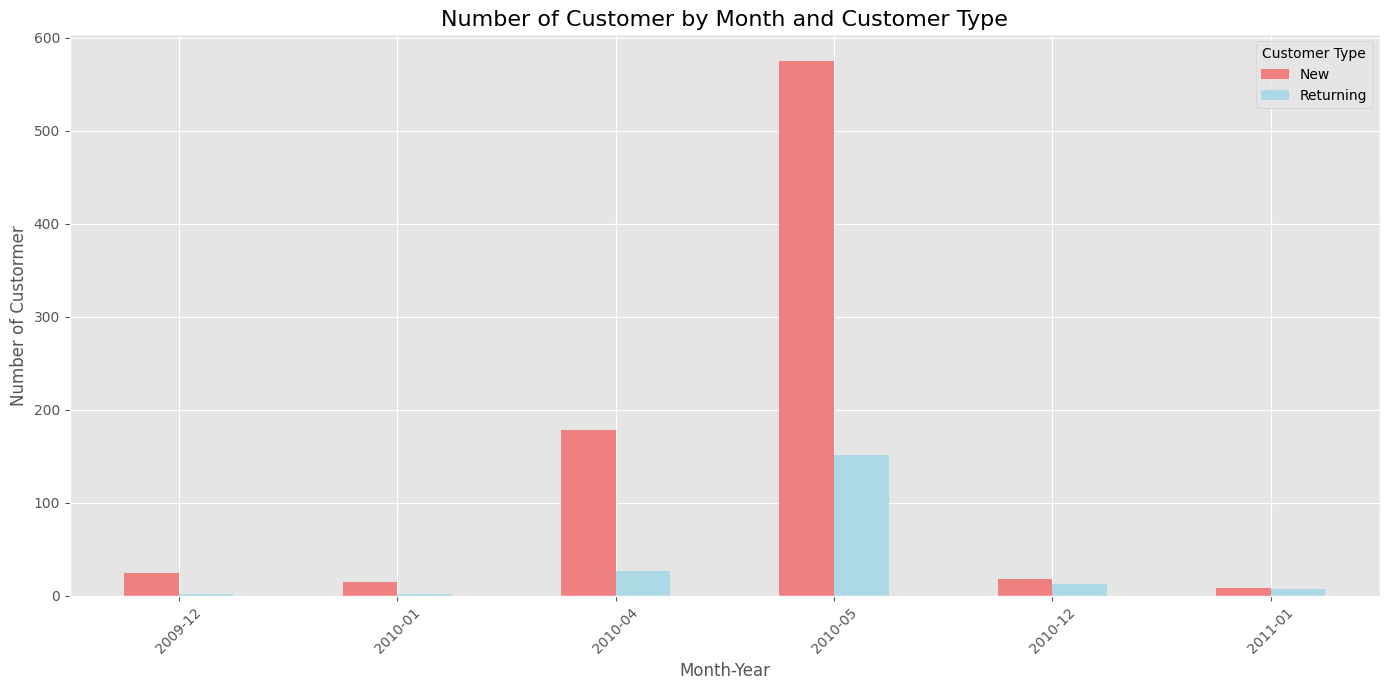

In [77]:
# Group by 'MonthYear' and 'CustomerType' to count unique Customer ID
month_by_type = data_df3.groupby(['MonthYear', 'CustomerType'])['Customer ID'].nunique().reset_index()

# Pivot the data for plotting
month_by_type_pivot = month_by_type.pivot(index='MonthYear', columns='CustomerType', values='Customer ID')

# Plot the bar chart
month_by_type_pivot.plot(kind='bar', figsize=(14, 7), color=['lightcoral', 'lightblue'])

plt.title('Number of Customer by Month and Customer Type', fontsize=16)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Number of Custormer', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Customer Type')
plt.tight_layout()  # Adjust layout for better display
plt.show()


With the above, we can confirm why we have more sales in the month of May, 2010. This period recorded the highest number of transactions by both new and returning customers

## RFM Analysis

In this section, we will cluster (segment) the customers using RFM (Recency, Frequency, Monetary) Analysis and then compliment our findings with predictive analysis using K-Means Clustering Algorithms

**Please Note**
* Recency (R): How recently a customer made a purchase (in Days)
* Frequency (F): How often a customer makes purchases
* Monetary (M): How much money a customer has spent.

In [97]:
# Calculate Recency, Frequency, and Monetary metrics

# Define snapshot_date as the day after the latest invoice date
snapshot_date = data_df3['InvoiceDate'].max() + dt.timedelta(days=1)

rfm_table = data_df3.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'Revenue': 'sum'
}).reset_index()

# Rename columns
rfm_table.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

In [98]:
# Assign R, F, and M scores using quantiles
rfm_table['R_Score'] = pd.qcut(rfm_table['Recency'], 4, labels=[4, 3, 2, 1])
rfm_table['F_Score'] = pd.qcut(rfm_table['Frequency'].rank(method="first"), 4, labels=[1, 2, 3, 4])
rfm_table['M_Score'] = pd.qcut(rfm_table['Monetary'], 4, labels=[1, 2, 3, 4])

In [99]:
# Create a combined RFM score
rfm_table['RFM_Score'] = rfm_table['R_Score'].astype(str) + rfm_table['F_Score'].astype(str) + rfm_table['M_Score'].astype(str)

In [100]:
# Segment customers based on RFM scores
def segment_customers(rfm):
    if int(rfm) >= 444:
        return 'Top Customer'
    elif int(rfm) >= 333:
        return 'Loyalist'
    elif int(rfm) >= 222:
        return 'Needs Attention'
    else:
        return 'At Risk'

rfm_table['Segment'] = rfm_table['RFM_Score'].apply(segment_customers)

In [101]:
# Checking the table
rfm_table.head(2)

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,12346.0,366,2,45.00,1,4,1,141,At Risk
1,12349.0,232,2,1268.52,4,4,4,444,Top Customer


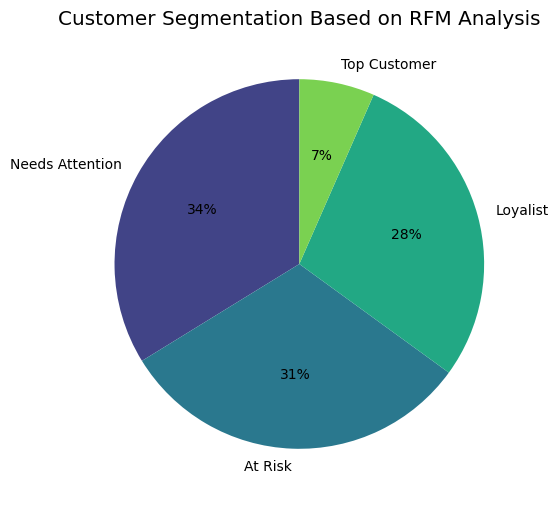

In [102]:
# Display summary of segments
segment_summary = rfm_table['Segment'].value_counts()

# Create a pie chart using matplotlib
plt.figure(figsize=(10, 6))
plt.pie(segment_summary, labels=segment_summary.index, autopct='%.0f%%', 
        colors=sns.color_palette('viridis', len(segment_summary)), startangle=90)

# Add title and labels
plt.title('Customer Segmentation Based on RFM Analysis')

# Display the plot
plt.show()

**Based on the RFM Analysis,31% of the customers (n=820) have not returned to make a purchase, indicating a risk of them becoming inactive or lost. The Ecommerce Company has just 7% Top customers,28% Loyalist and 34% of the customers are at the verge of becoming inactive or lost**

## RFM Distribution

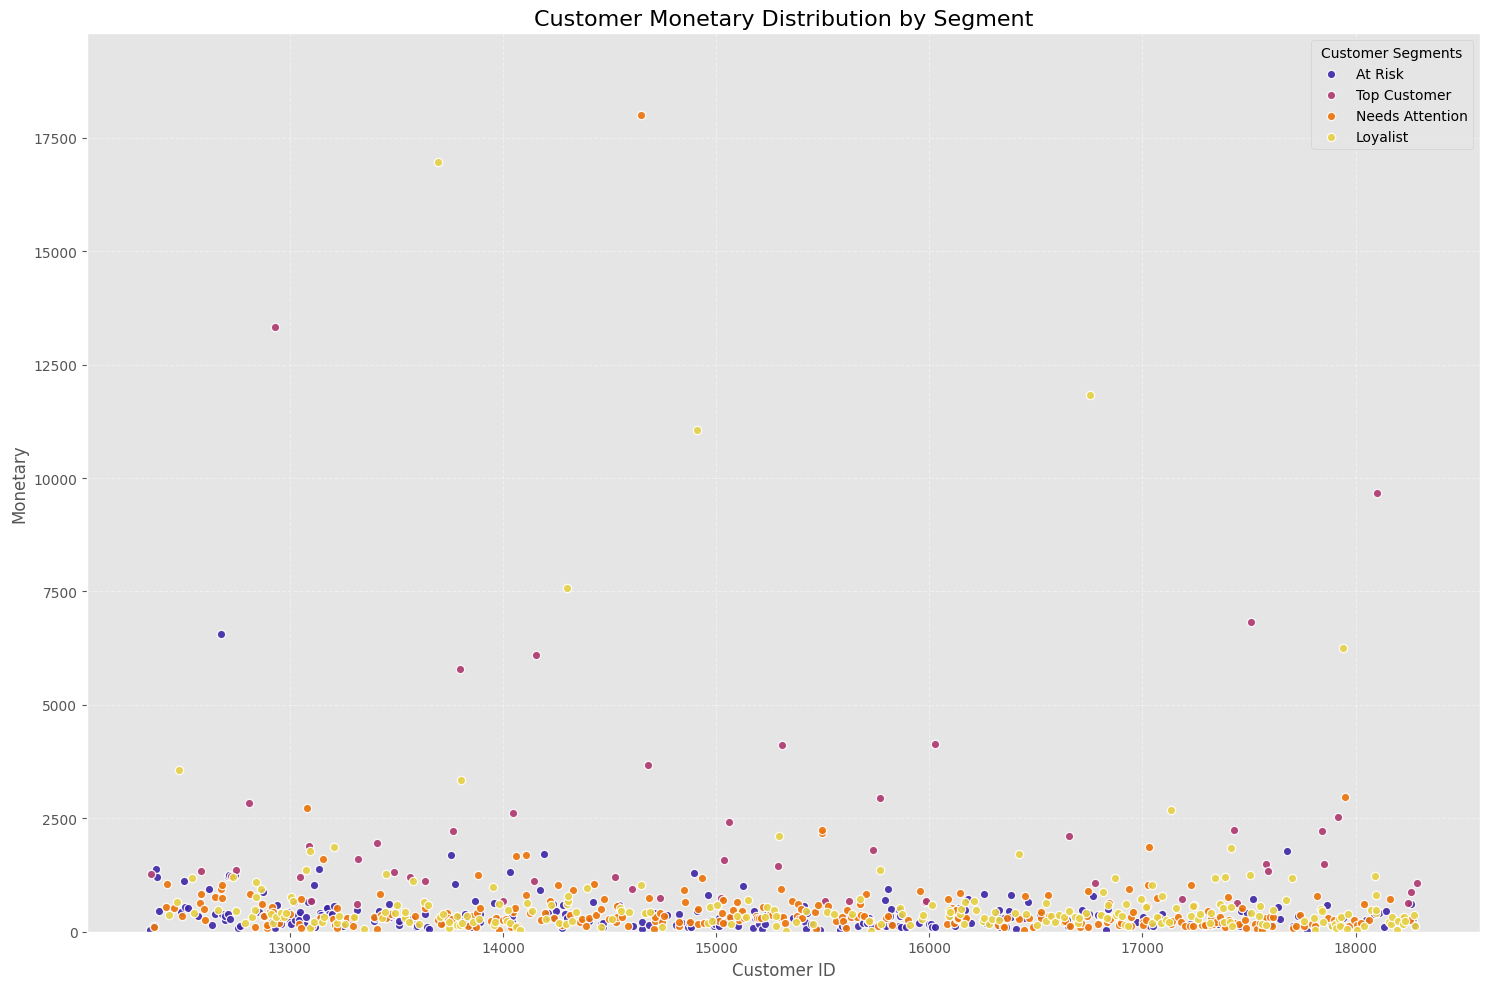

In [56]:
# Distribution Plot for Monetary
dist_plot(rfm_table,'Monetary')

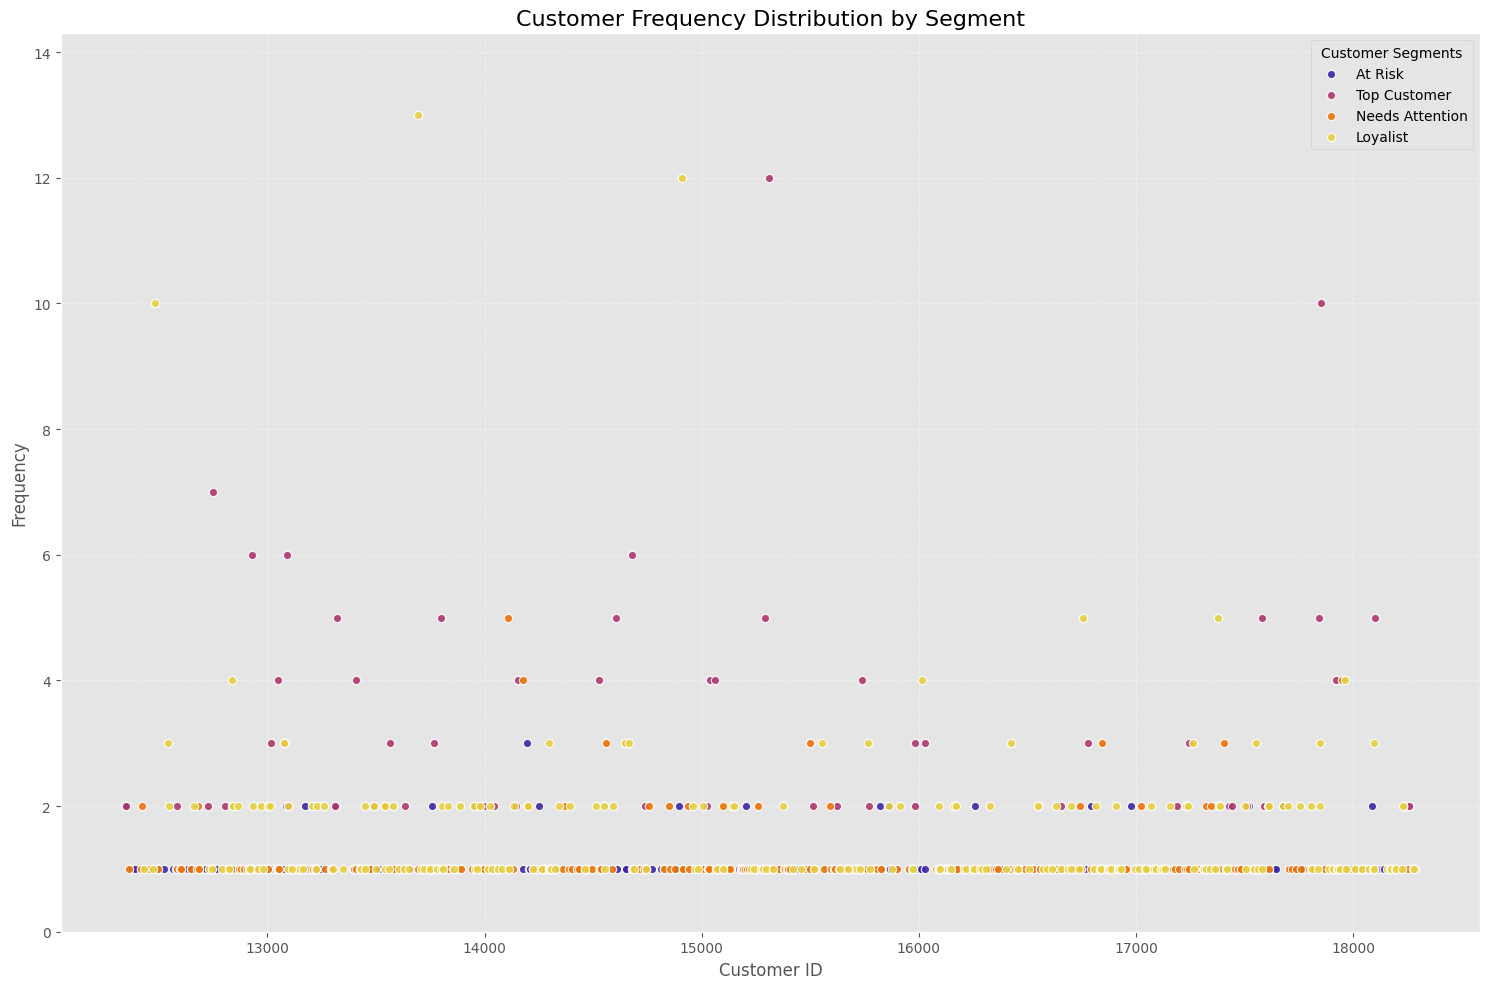

In [59]:
# Distribution Plot for Frequency
dist_plot(rfm_table,'Frequency')

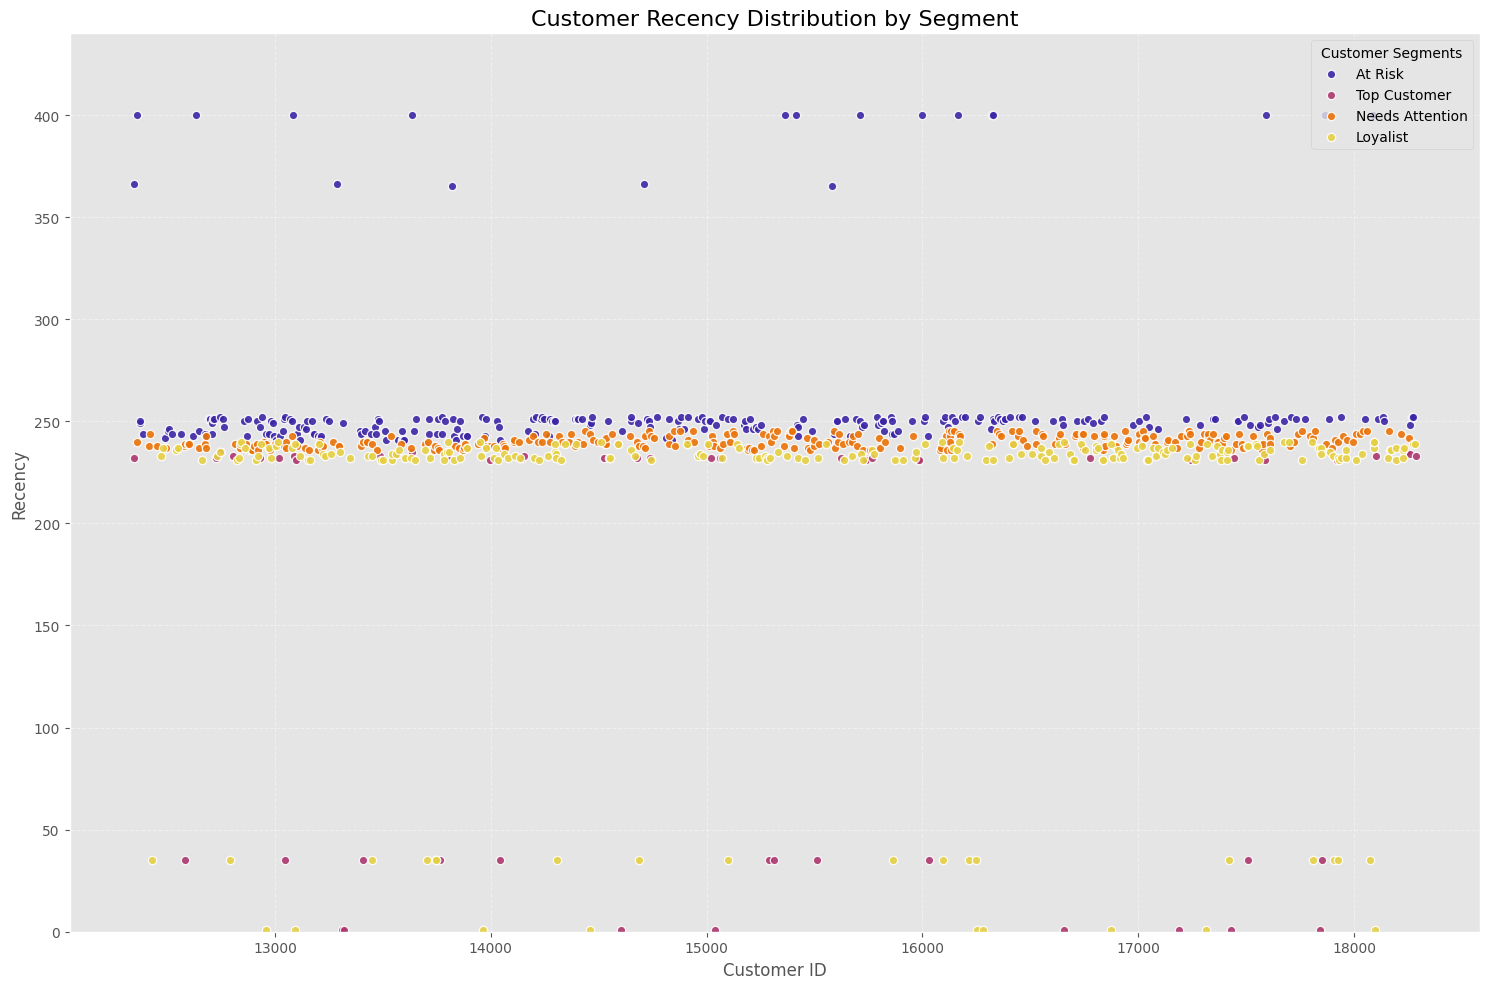

In [58]:
# Distribution Plot for Recency
dist_plot(rfm_table,'Recency')

## K-Means Clustering

Using RFM Analysis, we obtained 4 clusters based on customers' past purchasing behavior.
We can gain further insight into customer behavior by using `K-Means Algorithm` in conjuction with the RFM model

**Let add additional information about customers, such as Country, and Average Order Quantity**

In [103]:
# Get Customer Country
customer_country = data_df3.groupby('Customer ID')['Country'].max().reset_index()

In [104]:
# Get Average Order Quantity
aoq = total_qty_by_customer_invoice.groupby(['Customer ID']).mean()

In [106]:
first_purchase_date['Age'] = (snapshot_date-first_purchase_date['FirstPurchaseDate']).dt.days/365.25

In [107]:
# Combine all the data

# List of DataFrames to merge
dfs = [rfm_table, customer_country , aoq,first_purchase_date]

# Merge all DataFrames in the list on 'Customer ID'
kmeans_df = reduce(lambda left, right: pd.merge(left, right, on='Customer ID'), dfs)

In [108]:
# Check the dimension

kmeans_df.shape

(820, 13)

In [109]:
# Check the first 5 rows
kmeans_df.head()

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,Country,Quantity,FirstPurchaseDate,Age
0,12346.0,366,2,45.00,1,4,1,141,At Risk,United Kingdom,5.0,2010-01-04 09:24:00.000000296,1.002053
1,12349.0,232,2,1268.52,4,4,4,444,Top Customer,Italy,237.0,2010-04-29 13:20:00.000000556,0.687201
2,12361.0,240,1,98.15,3,1,1,311,Needs Attention,Belgium,38.0,2010-05-09 15:33:00.000000167,0.657084
3,12362.0,400,1,130.00,1,1,1,111,At Risk,Belgium,1.0,2009-12-01 10:09:59.999999860,1.095140
4,12374.0,249,1,1388.54,1,1,4,114,At Risk,Austria,798.0,2010-04-30 14:00:59.999999777,0.681725


#### Correlation Matrix

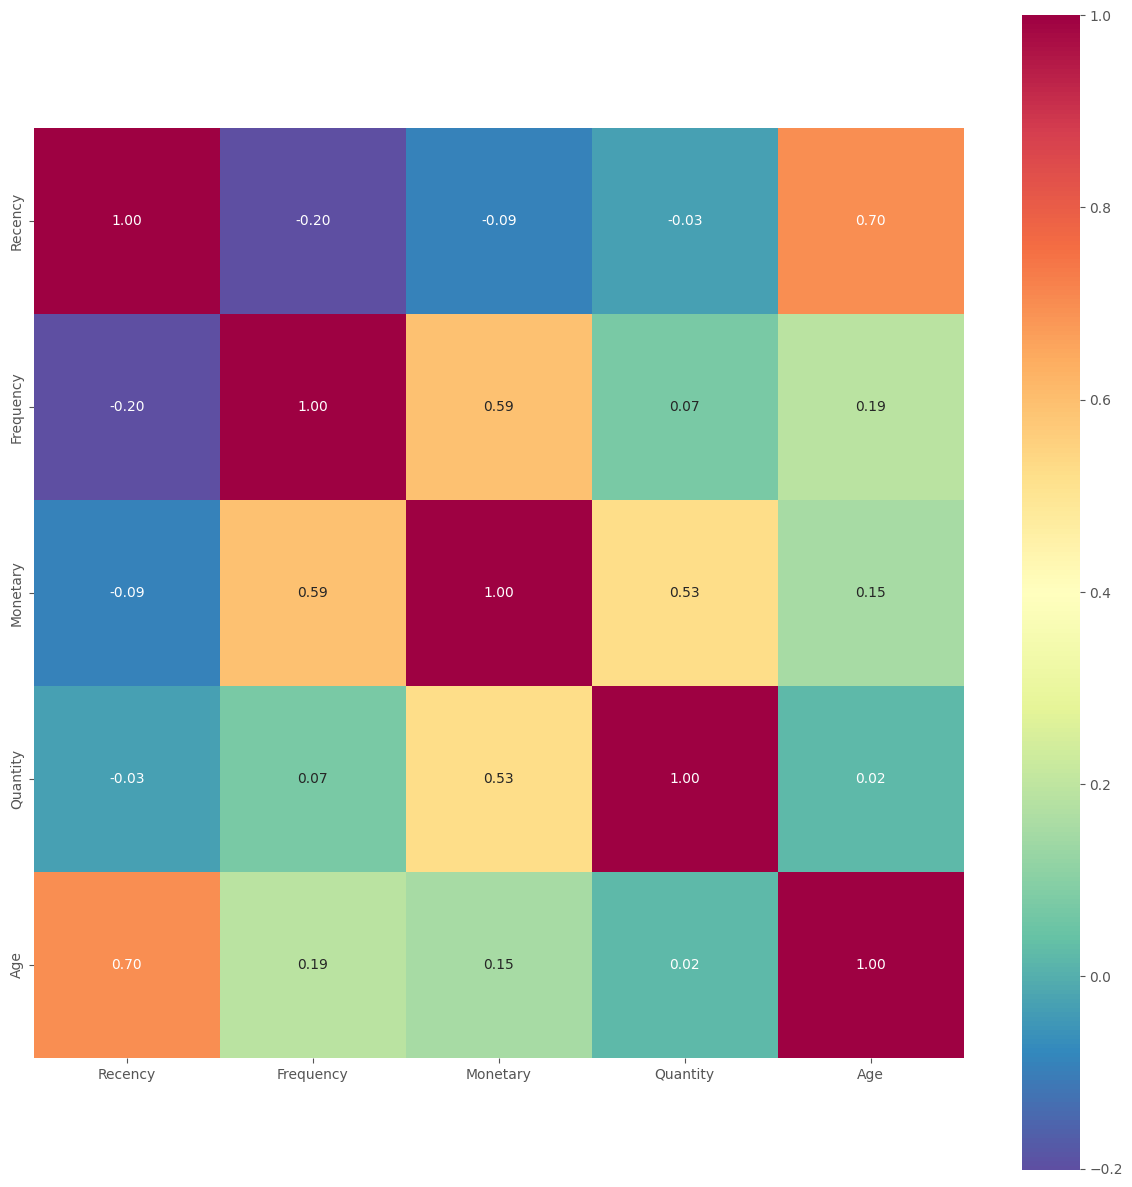

In [110]:
# Let's check for correlation

cormat(kmeans_df)

**There is no significant correlation between the variables except for Monetary Value which has a moderate correlation with Average Order Quantity and Frequency**

**However, Age is strongly correlated with Recency. This stems from the fact that they are both functions of last transaction date. As such, this will dropped in other to not distort the analysis**

In [111]:
# First Drop Un-used columns
kmeans_df1 = kmeans_df.set_index('Customer ID')

# Drop Customer ID, R_Score,F_Score,M_Score,RFM_Score,Segment
kmeans_df1 = kmeans_df1.drop(columns=[ 'R_Score', 'F_Score','M_Score', 'RFM_Score', 'Segment',"Age",'FirstPurchaseDate'])

In [112]:
kmeans_df1.head()

,Recency,Frequency,Monetary,Country,Quantity
Customer ID,,,,,
12346.0,366,2,45.00,United Kingdom,5.0
12349.0,232,2,1268.52,Italy,237.0
12361.0,240,1,98.15,Belgium,38.0
12362.0,400,1,130.00,Belgium,1.0
12374.0,249,1,1388.54,Austria,798.0


#### Kmeans Algorithm Pipeline

Here, we will apply one-hot encoding to the `Categorical variable (Country), because it is a nominal data, and then MinMaxScaler to other data using Pipeline

In [114]:
# Extract categorical and numerical columns
categorical_features = kmeans_df1.select_dtypes(include=['object']).columns
numerical_features = kmeans_df1.select_dtypes(include=['float64', 'int64']).columns

In [124]:
# Preprocessing for numerical and categorical data
numerical_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder(drop='first',sparse_output=False)

# Combine preprocessors in a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

We need to first find the optimal Number of Clusters using a combination of Silhouette Score and Elbow Method

#### Elbow Method

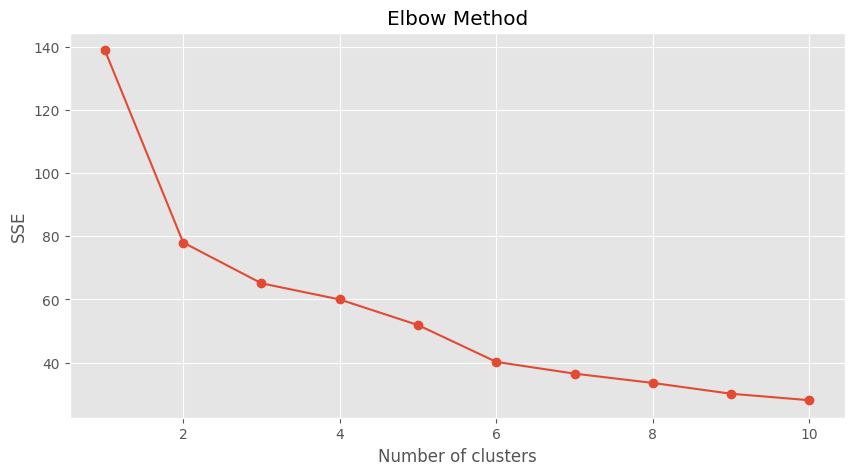

In [125]:
# Elbow method
sse = []
for k in range(1, 11):
    pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=k,random_state=42))])
    pipeline.fit(kmeans_df1)

     # Access inertia_ from the KMeans model in the pipeline
    sse.append(pipeline.named_steps['kmeans'].inertia_)
0
# Plot the Elbow method
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

#### Silhouette scores

In [126]:
# Silhouette scores
for k in range(2, 11):
    # Create a pipeline that includes preprocessing and the KMeans clustering model
    pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=k,random_state=42))])
    
    # Fit the pipeline and predict the cluster labels
    labels = pipeline.fit_predict(kmeans_df1)

    # Get the transformed data after preprocessing
    transformed_data = pipeline.named_steps['preprocessor'].transform(kmeans_df1)
    
    # Calculate the Silhouette score
    score = silhouette_score(transformed_data, labels)
    print(f'Number of clusters: {k}, Silhouette Score: {score:.3f}')

Number of clusters: 2, Silhouette Score: 0.840
Number of clusters: 3, Silhouette Score: 0.788
Number of clusters: 4, Silhouette Score: 0.792
Number of clusters: 5, Silhouette Score: 0.800
Number of clusters: 6, Silhouette Score: 0.814
Number of clusters: 7, Silhouette Score: 0.819
Number of clusters: 8, Silhouette Score: 0.818
Number of clusters: 9, Silhouette Score: 0.820
Number of clusters: 10, Silhouette Score: 0.822


Based on the above, the k value that gives a strong balance of a lower SSE (from the Elbow plot) and a high silhouette score is 4

#### Model Pipeline

In [127]:
# k means using 4 clusters

# Create a pipeline that includes preprocessing and the KMeans clustering model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=4,random_state=42))
])

In [128]:
# Fit the pipeline
pipeline.fit(kmeans_df1)

# Predict cluster labels
kmeans_df['Cluster'] = pipeline.predict(kmeans_df1)

In [129]:
kmeans_df.head()

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,Country,Quantity,FirstPurchaseDate,Age,Cluster
0,12346.0,366,2,45.00,1,4,1,141,At Risk,United Kingdom,5.0,2010-01-04 09:24:00.000000296,1.002053,0
1,12349.0,232,2,1268.52,4,4,4,444,Top Customer,Italy,237.0,2010-04-29 13:20:00.000000556,0.687201,2
2,12361.0,240,1,98.15,3,1,1,311,Needs Attention,Belgium,38.0,2010-05-09 15:33:00.000000167,0.657084,2
3,12362.0,400,1,130.00,1,1,1,111,At Risk,Belgium,1.0,2009-12-01 10:09:59.999999860,1.095140,2
4,12374.0,249,1,1388.54,1,1,4,114,At Risk,Austria,798.0,2010-04-30 14:00:59.999999777,0.681725,2


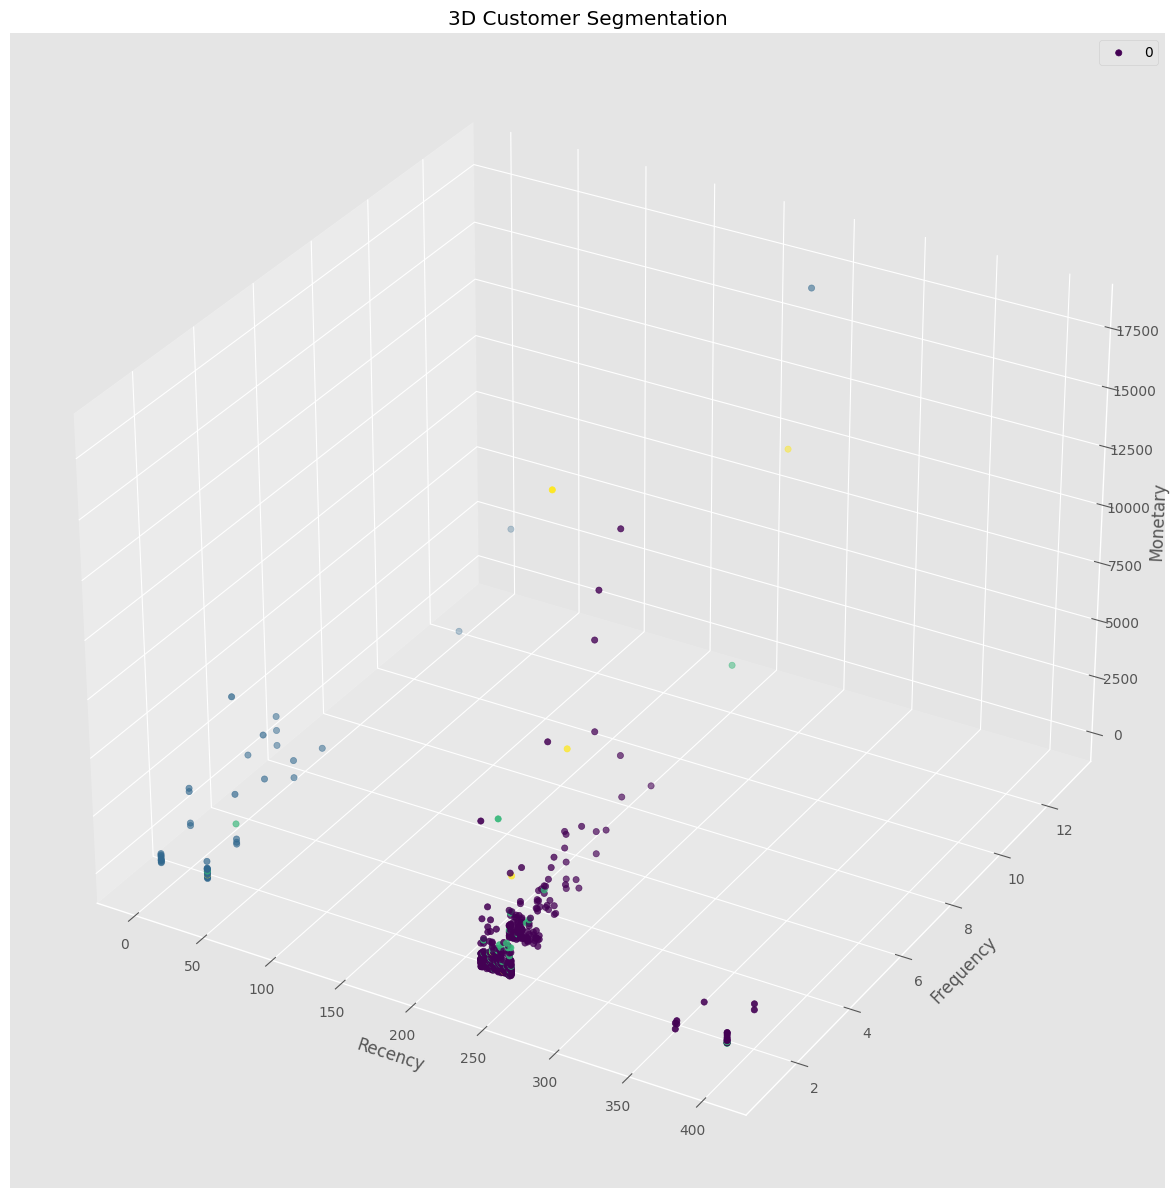

In [130]:
# Distribution by RFM
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(kmeans_df['Recency'],  kmeans_df['Frequency'],kmeans_df['Monetary'], c=kmeans_df['Cluster'], cmap='viridis')
ax.set_title('3D Customer Segmentation')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.legend(kmeans_df['Cluster'].unique())
plt.show()

In [131]:
# Checking the Average  for these 4 Clusters
kmeans_df.groupby(['Cluster'])[['Recency','Frequency','Monetary','Quantity']].mean()

,Recency,Frequency,Monetary,Quantity
Cluster,,,,
0,244.157601,1.309623,510.403432,229.395909
1,26.431818,2.590909,1438.492727,315.881643
2,243.173077,1.365385,836.042115,377.530128
3,209.857143,3.428571,5593.042857,1006.000000


#### Interpretations

* Cluster 0:  low engagement, low-spending customers who have not purchased in a while. They might be at risk of churn or only engage occasionally
* Cluster 1: customers are active and valuable due to their frequent purchases and high spending. They represent a loyal segment with consistent buying behavior.
* Cluster 2: bulk buyers who make substantial purchases but are not very frequent or recent buyers. They may buy in bulk for special needs or occasional stock-ups.
* Cluster 3: top-spending, high-frequency bulk buyers. They make significant contributions to overall revenue with their consistent, large purchases

In [132]:
kmeans_df['Cluster'] = kmeans_df['Cluster'].replace({0:'At Risk',1:'Loyalist',2:'Needs Attention',3:' Top'})

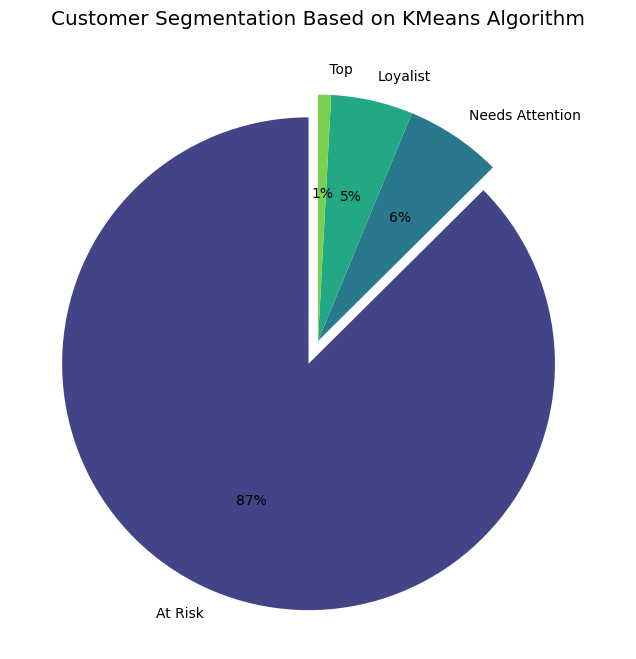

In [134]:
# Display summary of segments
segment_summary = kmeans_df['Cluster'].value_counts()
explode = (0.1, 0, 0, 0)
# Create a pie chart using matplotlib
plt.figure(figsize=(10, 8))
plt.pie(segment_summary, labels=segment_summary.index, autopct='%.0f%%',explode = explode,
        colors=sns.color_palette('viridis', len(segment_summary)), startangle=90)

# Add title and labels
plt.title('Customer Segmentation Based on KMeans Algorithm')

# Display the plot
plt.show()

**The Top Customers are 1% of the customer-base, while Loyalists, and customers that are at risk of churning or need attention make up 5%, 87% and 6% (approx.) respectively**

#### Clusters Distribution

In [136]:
# Distribution by Country
df_country = kmeans_df.groupby(['Country','Cluster'])['Customer ID'].count().reset_index()

customer_by_cpountry = df_country.pivot(index='Country',columns='Cluster',values='Customer ID')

**The above shows that, whereas United Kindgom is the hottest Market in terms of Revenue, all the Top Customers are from other countries such as Ireland and Netherlands. Most of the customers in UK are at risk of churning**

In [137]:
# Save to disk

customer_by_cpountry.to_csv("./processed_data/customersegmentation_by_country.csv",index=False)

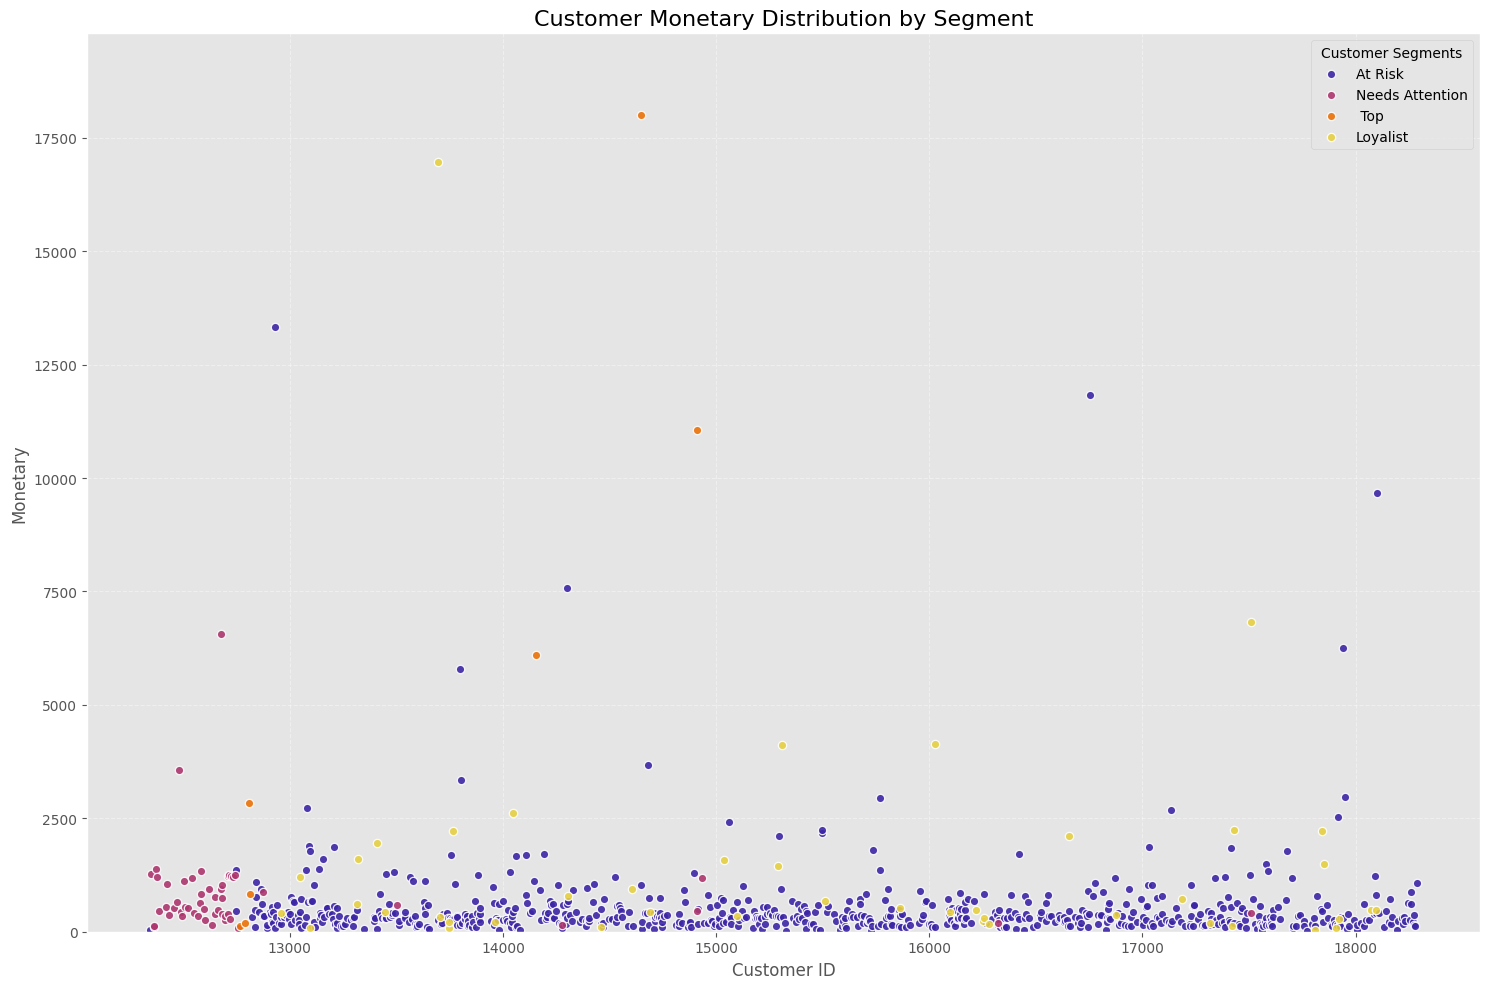

In [138]:
# let's look at the distribution of the clusters

dist_plot(kmeans_df,'Monetary',True)

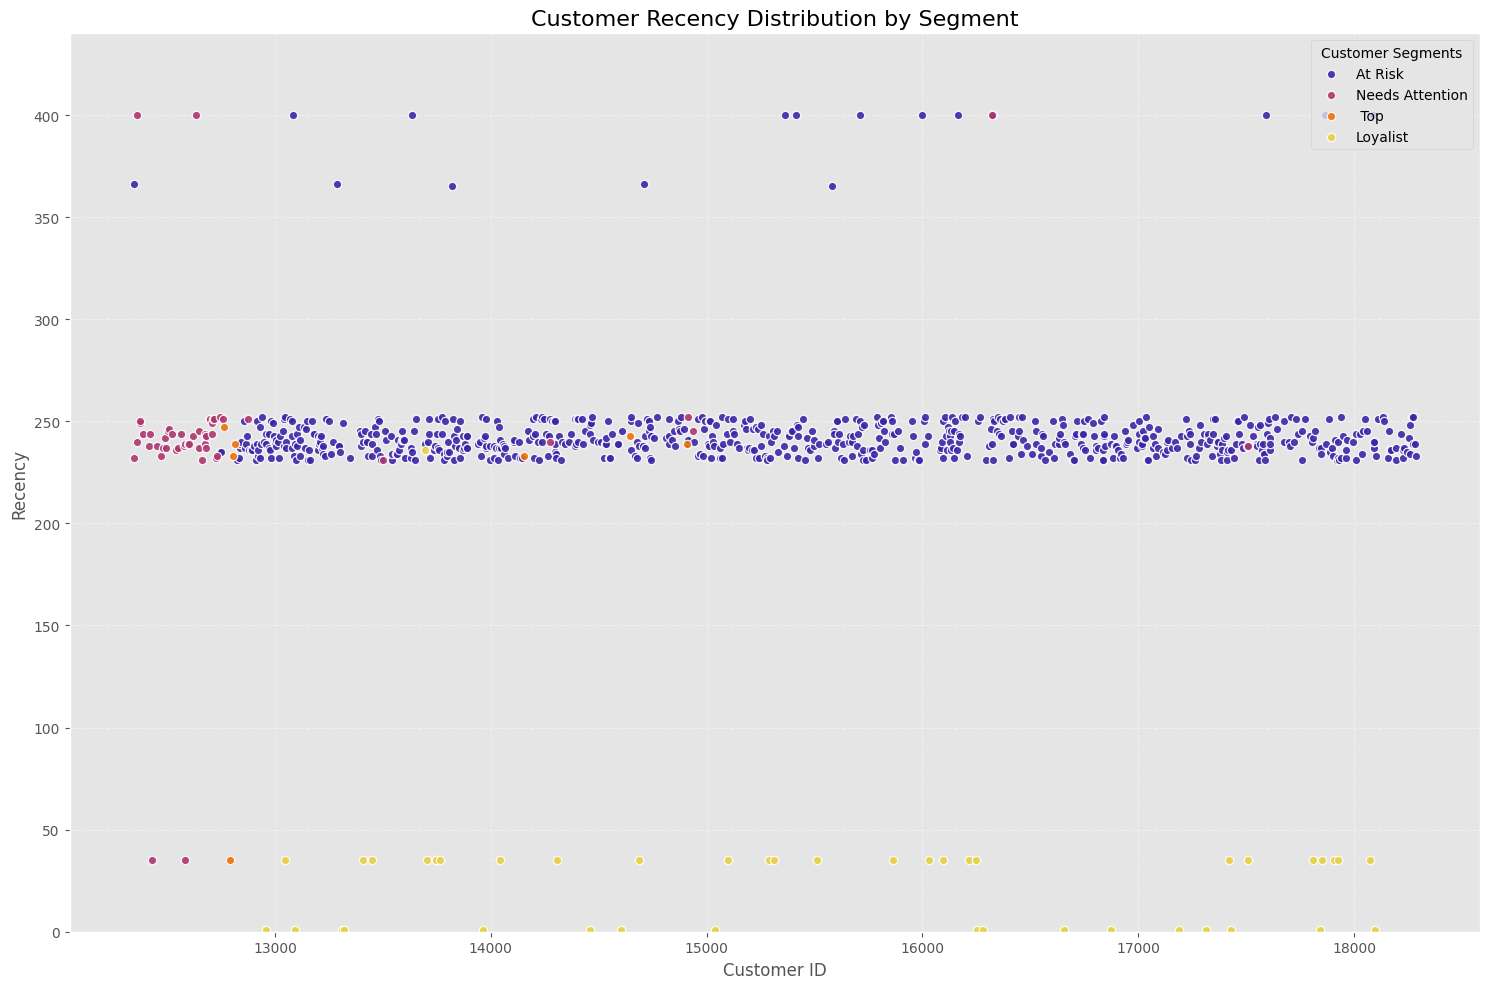

In [139]:
dist_plot(kmeans_df,'Recency',True)

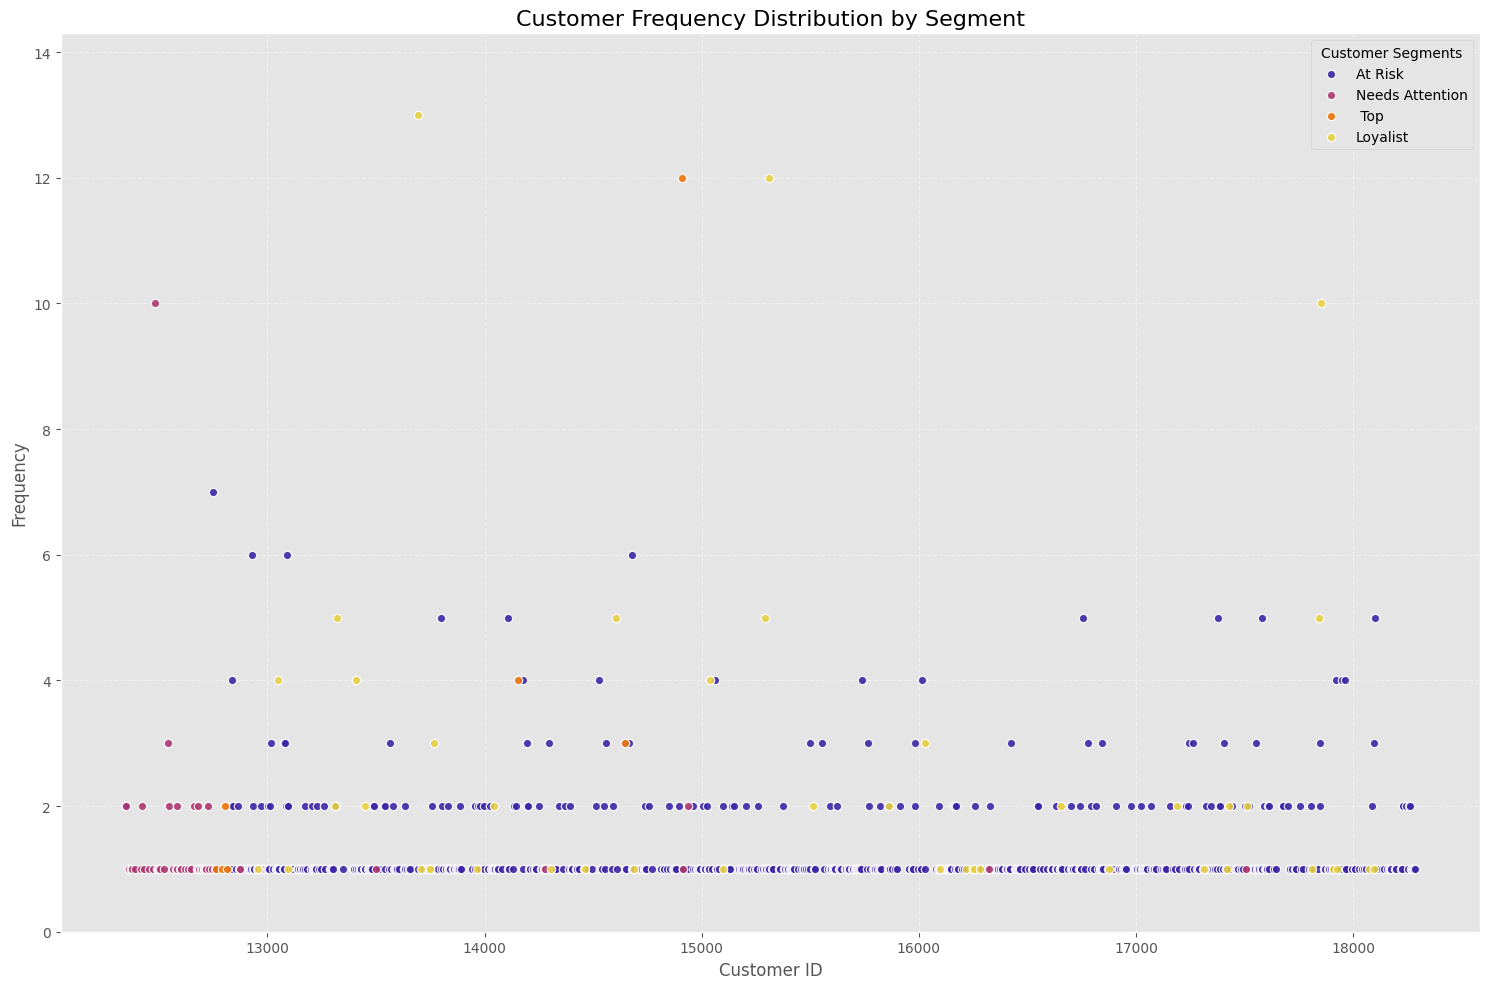

In [140]:
dist_plot(kmeans_df,'Frequency',True)

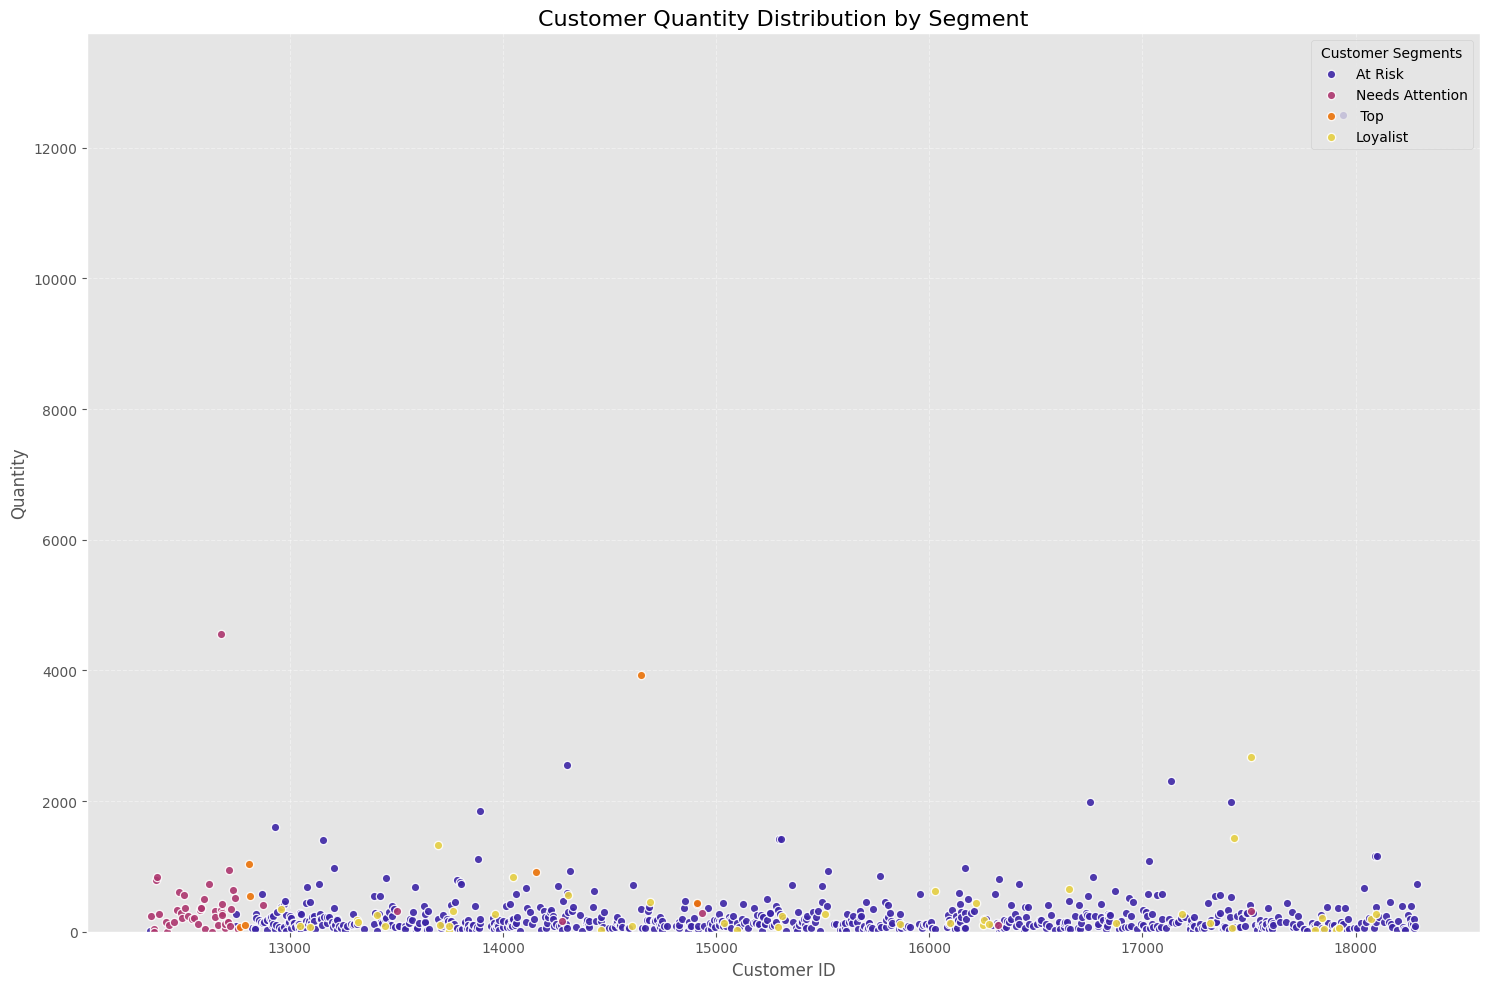

In [141]:
dist_plot(kmeans_df,'Quantity',True)

## Save Model and Data (Optional)

In [142]:
# create folder for saving model and its parameters
os.makedirs('model',exist_ok=True)

# Save the model
with open('./model/kmeans_customer_segmentation.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [143]:
# Save the final data to disk
kmeans_df.to_csv("./processed_data/segmented_data.csv",index=False)